# Covid-19 und Feinstaubdatenanalyse

In der folgenden Datenanalyse wurden die Covid19-Daten des RKI und die Feinstaubdaten des Bundesministeriums zur Analyse verwendet. Es wurde untersucht ob die Daten miteinander korrelieren.
Für die Datengewinnung und Datenbearbeitung wurde Pandas, numpy und scipy verwendet.
Für das ploten der Daten, wurde die Matplotlib verwendet.

- Gruppenmitglieder:
    * Anna Kuhn 
    * Benjamin Hamm
    * Michael Schulze
    * Jan Klotter

In [1]:
#Abhängigkeiten importieren

import pandas as pd
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta
import numpy as np
from scipy.stats import pearsonr
import collections
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.dates as mdates

## 1. Datenaufbereitung 

Datenquellen:

- RKI Corona Daten Stand 11.01.2021
 https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0/data
 
- Umweltbundesamt Luftdaten der Station Mannheim Friedrichsring (DEBW098)
 https://www.umweltbundesamt.de/daten/luft/luftdaten/luftqualitaet/eJzrWJSSuMrIwMhQ18BQ19BoUUnmIkODRXmpCxYVlyw2srRcnOJWBJc3MF2cEpKPrDy3imNRbnLT4pzEktMOHtdiz0_Nmrk4Jy_9tIOS9gMGBgZGAIslIvw=


Als ersten Schritt müssen die Daten aufbereitet werden. Die Corona-Daten von Mannheim liegen in mehreren Einträgen vor und müssen deshalb auf einen Tag aufsummiert werden. Fehlende Einträge werden auf 0 gesetzt.

In [2]:
#Daten aus Datei auslesen mithilfe von Pandas

covid_data_germany = pd.read_csv('RKI_COVID19.csv')
feinstaub_data_mannheim = pd.read_csv('Luftqualitaet.csv',sep=';')

Die folgende Zelle filtriert die Corona-Daten aus Mannheim heraus und lediglich alle Daten aus dem Jahr 2020.

In [3]:
#Corona Daten nach Landkreis Mannheim filtern
covid_data_mannheim = covid_data_germany[covid_data_germany['Landkreis'] == 'SK Mannheim' ]

#Corona Daten nach Datum sortieren
#sortedByDate_covid_data_mannheim = covid_data_mannheim.sort_values(by='Refdatum')

#2021 Werte aussortiert
covid_data_mannheim = covid_data_mannheim[
        covid_data_mannheim['Refdatum'] <= '2020/12/31 00:00:00' ]


Die Feinstaubdaten hatten viele Leerdaten, welche aussortiert werden mussten.

In [4]:
#Tage an denen nicht aufgenommen wurde aussortieren
feinstaub_data_mannheim = feinstaub_data_mannheim[feinstaub_data_mannheim['Feinstaub (PM₁₀) stündlich gleitendes Tagesmittel in µg/m³'] != '-']

#Umweltbundesamt Eintrag aussortieren
feinstaub_data_mannheim = feinstaub_data_mannheim[:-2]

Damit die Anzahl der Covid-19-Fälle mit den Feinstaubdaten verglichen werden kann, muss ein Tagesmittel für die Feinstaubdaten ausgerechnet werden. Die Covid-19-Fälle müssen auch gefiltert werden.
Dadurch kann man die Anzahl der Covid-19-Fällen gegenüber den Tagesmittel der Feinstaubdaten korrelieren lassen.

In [5]:
#Fallzahlen und Todeszahlen pro Tag bestimmen

neuinfektionen_nach_datum = {}
todesfaelle_nach_datum = {}

for key, value in enumerate(covid_data_mannheim['Refdatum']):
    if value[:10] not in neuinfektionen_nach_datum:
        todesfaelle_nach_datum[value[:10]] = [np.array(covid_data_mannheim['AnzahlTodesfall'])[key]]
        neuinfektionen_nach_datum[value[:10]] = [np.array(covid_data_mannheim['AnzahlFall'])[key]]
    else:
        todesfaelle_nach_datum[value[:10]].append(np.array(covid_data_mannheim['AnzahlTodesfall'])[key])
        neuinfektionen_nach_datum[value[:10]].append(np.array(covid_data_mannheim['AnzahlFall'])[key])
        
        wert = neuinfektionen_nach_datum[value[:10]]
        neuinfektionen_nach_datum[value[:10]] = [np.sum(np.array(wert))]
    
        wert = todesfaelle_nach_datum[value[:10]]
        todesfaelle_nach_datum[value[:10]] = [np.sum(np.array(wert))]

In [6]:
#Tagesmittel Feinstaub (PM₁₀) pro Tag bestimmen

feinstaub_data_mannheim_nach_datum = {}

for key, value in enumerate(feinstaub_data_mannheim['Datum']):
    if type(value) is float:
        break;
        
    new_date = str(datetime.strptime(value.strip("'")[:10],"%d.%m.%Y"))[:10]
    
    if new_date not in feinstaub_data_mannheim_nach_datum:
        
        feinstaub_data_mannheim_nach_datum[new_date] = [np.array(feinstaub_data_mannheim['Feinstaub (PM₁₀) stündlich gleitendes Tagesmittel in µg/m³'])[key]]
    else:
        
        feinstaub_data_mannheim_nach_datum[new_date].append(np.array(feinstaub_data_mannheim['Feinstaub (PM₁₀) stündlich gleitendes Tagesmittel in µg/m³'])[key])

Tage an denen keine Feinstaubdaten aufgenommen wurden, müssen 0 gesetzt werden. Sonst werden NaN-Werte korreliert.

In [7]:
#Tage ohne Neuinfektionen oder Toden nachtragen

for datum in feinstaub_data_mannheim_nach_datum.keys():
    
    if datum.replace("-", "/") not in neuinfektionen_nach_datum.keys():
        
        neuinfektionen_nach_datum[datum.replace("-", "/")] = [0]
        todesfaelle_nach_datum[datum.replace("-", "/")] = [0]
    
    feinstaub_data_mannheim_nach_datum[datum] = np.mean(np.array(feinstaub_data_mannheim_nach_datum[datum]))


Die Daten müssen nach passenden Datum sortiert werden, da sonst falsche Tagesdaten miteinander korreliert werden.

In [8]:
#Datum in richtiger Reihenfolge
sorted_neuinfektionen_nach_datum = collections.OrderedDict(sorted(neuinfektionen_nach_datum.items()))
sorted_todesfaelle_nach_datum = collections.OrderedDict(sorted(todesfaelle_nach_datum.items()))
sorted_feinstaub_data_mannheim_nach_datum = collections.OrderedDict(sorted(feinstaub_data_mannheim_nach_datum.items()))

anzahl_faelle_list = list(sorted_neuinfektionen_nach_datum.values())
anzahl_tode_list = list(sorted_todesfaelle_nach_datum.values())
feinstaub_list = list(sorted_feinstaub_data_mannheim_nach_datum.values())

for key, value in enumerate(anzahl_faelle_list):
    anzahl_faelle_list[key] = anzahl_faelle_list[key][0]
    anzahl_tode_list[key] = anzahl_tode_list[key][0]

## 2.Explorative Datenanalyse

Im folgenden Abschnitt werden die Daten geplotet.

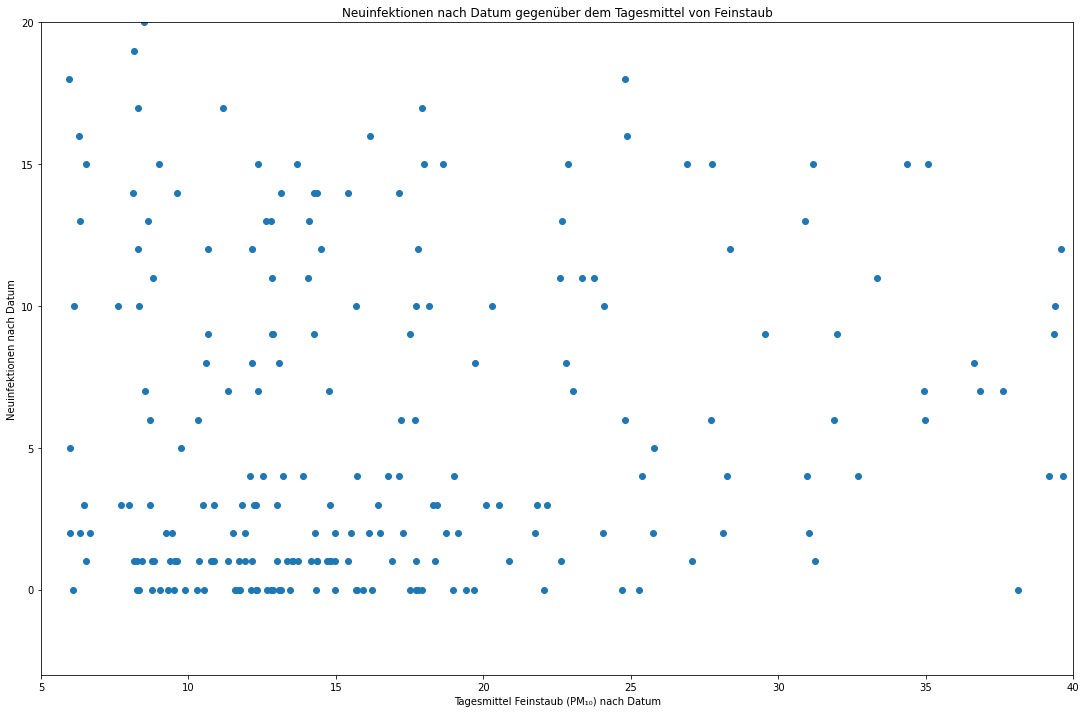

0.12346439885572025


In [9]:

plt.scatter(feinstaub_list, anzahl_faelle_list)
fig = plt.gcf()
fig.set_size_inches(18.5,12)
plt.xlim([5,40])
plt.ylim([-3,20])
plt.title("Neuinfektionen nach Datum gegenüber dem Tagesmittel von Feinstaub")
plt.ylabel("Neuinfektionen nach Datum")
plt.xlabel("Tagesmittel Feinstaub (PM₁₀) nach Datum")
plt.show()

corr,_= pearsonr(feinstaub_list, anzahl_faelle_list)
print(corr)

Aus dem Scatterplot kann man noch keinen linearen Zusammenhang zwischen den Daten erkennen.
Es sieht sehr gestreut aus.

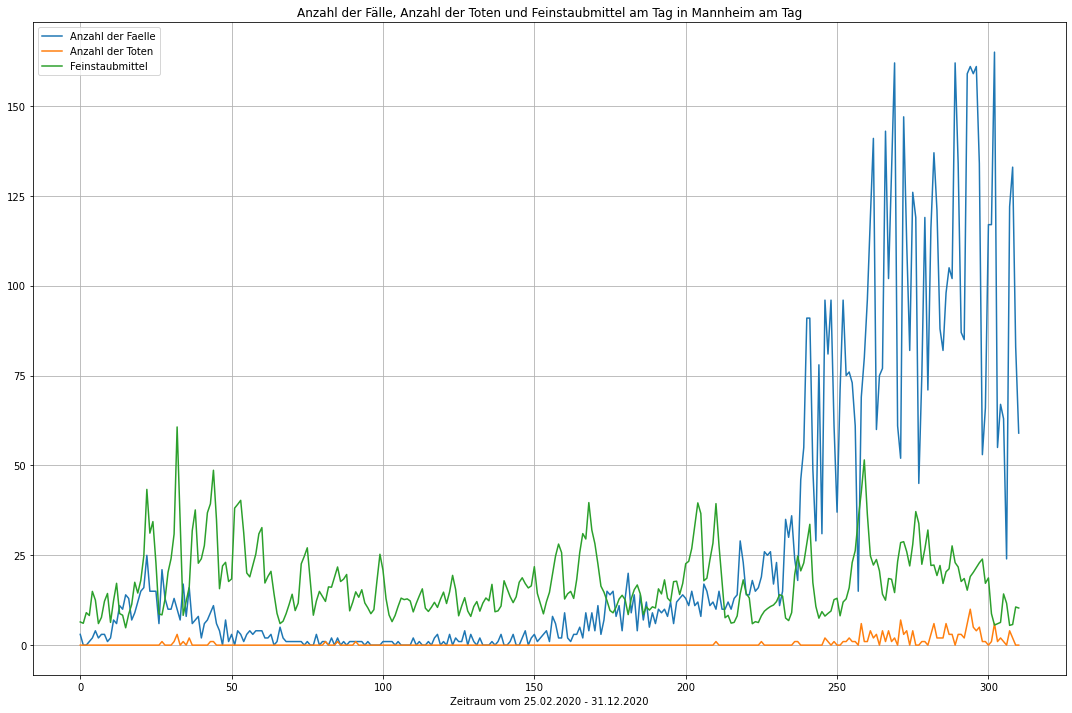

In [10]:
plt.plot(anzahl_faelle_list,label="Anzahl der Faelle")
plt.plot(anzahl_tode_list,label="Anzahl der Toten")
plt.plot(feinstaub_list,label="Feinstaubmittel")
fig = plt.gcf()
fig.set_size_inches(18.5,12)
plt.title("Anzahl der Fälle, Anzahl der Toten und Feinstaubmittel am Tag in Mannheim am Tag")
plt.xlabel("Zeitraum vom 25.02.2020 - 31.12.2020")
plt.legend()
plt.grid()
plt.show()

Anhand der Daten erkennt man schon teilweise eine gewisse Korrelation. Sobald die Feinstaub-Daten sich erhöhen, erhöhen sich auch die Anzahl der Faelle.

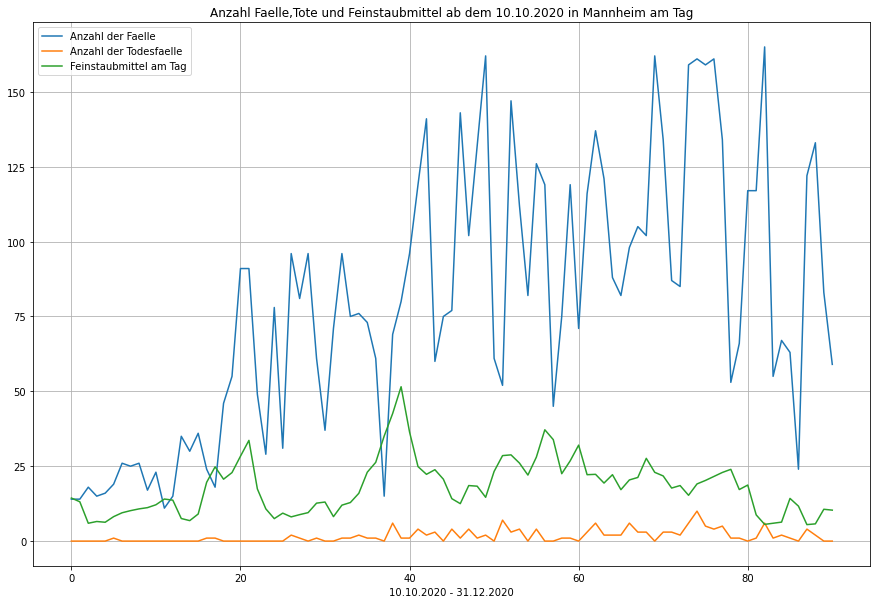

In [11]:
plt.plot(anzahl_faelle_list[220:],label="Anzahl der Faelle")
plt.plot(anzahl_tode_list[220:],label="Anzahl der Todesfaelle")
plt.plot(feinstaub_list[220:],label="Feinstaubmittel am Tag")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("Anzahl Faelle,Tote und Feinstaubmittel ab dem 10.10.2020 in Mannheim am Tag")
plt.xlabel("10.10.2020 - 31.12.2020")
plt.legend()
plt.grid()
plt.show()

Im folgenden Plot wurde der Moving-Average der Anzahl der Todesfälle und die Anzahl der Corona-Fälle in Mannheim von 7 Tagen geplottet. (Da das RKI am Wochenende nur wenig Daten übermittel bekommt, haben wir auf eine Woche gerundet, damit die Wochenendschwankungen herausgefiltert werden.)

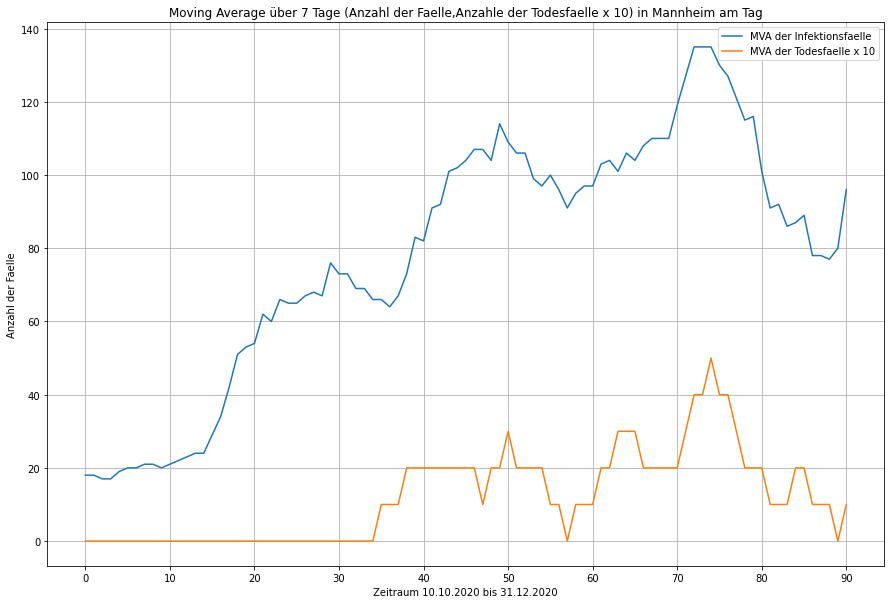

In [12]:
N = 7
anzahl_faelle_list_rm = uniform_filter1d(anzahl_faelle_list, size=N)
anzahl_tode_list_rm = uniform_filter1d(anzahl_tode_list, size=N)

plt.plot(anzahl_faelle_list_rm[220:],label="MVA der Infektionsfaelle")
plt.plot(anzahl_tode_list_rm[220:] * 10,label="MVA der Todesfaelle x 10")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.legend()
plt.title("Moving Average über 7 Tage (Anzahl der Faelle,Anzahle der Todesfaelle x 10) in Mannheim am Tag")
plt.xlabel("Zeitraum 10.10.2020 bis 31.12.2020")
plt.xticks(range(0,100,10))
plt.ylabel("Anzahl der Faelle")
plt.grid()
plt.show()

Anhand der Abbildung erkennt man sehr gut, dass nach einem Peak der Infektionen, ein Paar Tage später die Todeszahlen ansteigen. Da wie gesagt, ein Anstieg der Infektionszahlen erst zeitversetzt einen Anstieg der Todeszahlen verursacht, wurden die Korrelation für verschiedene Tagesdifferenzen (0 bis 50) zwischen Infektionszeitpunkt und Todeszeitpunkt ermittelt.

Maximum von 0.64 nach 20 Tagen


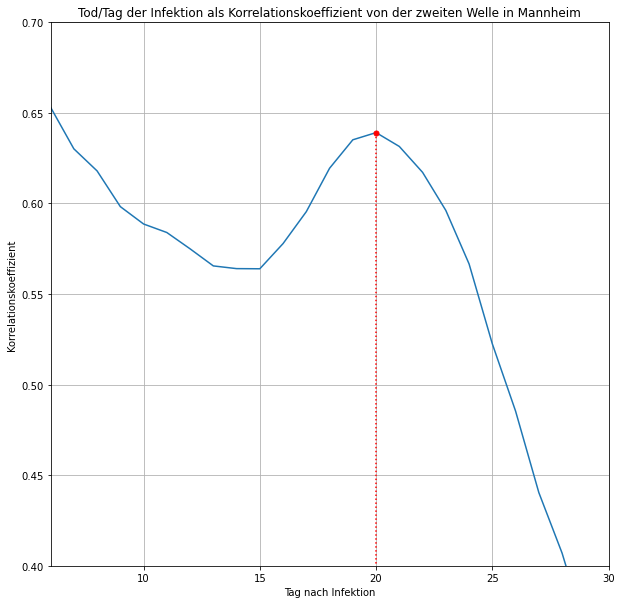

In [13]:
corrs = []
#anzahl_faelle_float = list(map(float, anzahl_faelle_list_rm ))
#anzahl_tode_float = list(map(float, anzahl_tode_list_rm )) 

anzahl_faelle_float = [float(elem) for elem in anzahl_faelle_list_rm]
anzahl_tode_float = [float(elem) for elem in anzahl_tode_list_rm]

for i in range(1,50):
    corr,p= pearsonr(anzahl_faelle_list_rm[220:-i], anzahl_tode_list_rm[220+i:])
    corrs.append(corr)

    
corr_max = np.max(corrs[10:])
corr_arg_max = np.argmax(corrs[10:])+10

print("Maximum von "+ str(round(corr_max,2)) + " nach " + str(corr_arg_max) + " Tagen")

plt.plot(corrs,label="Korrelationskoeffizient der Infektionsfaellen zu den Todesfaellen")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.xlabel("Tag nach Infektion")
plt.title("Tod/Tag der Infektion als Korrelationskoeffizient von der zweiten Welle in Mannheim")
plt.ylabel("Korrelationskoeffizient")
plt.xlim([6,30])
plt.ylim([0.4,0.7])
plt.plot(corr_arg_max, corr_max, marker='o', markersize=5, color="red")
plt.vlines(corr_arg_max,0,corr_max,color='red', linestyle='dotted')
plt.grid()
plt.show()

0.64 als Korrelationskoeffizient nach 20 Tagen, in klinischen Studien ist das eine Korrelation.
(Korrelation bei 0-5 Tagen Differenz auch sehr hoch aus unbekanntem Grund, vielleicht durch niedrige Todeszahlen in Mannheim)

# Vergleich mit Deutschland
Zum Vergleich werden die Daten von gesamt Deutschland dargestellt. Zur besseren Visualisierung der Korrelation wird die Anzahl der Toten um den Faktor 10 erhöht und mit den Infektionszahlen in einem Plot dargestellt.

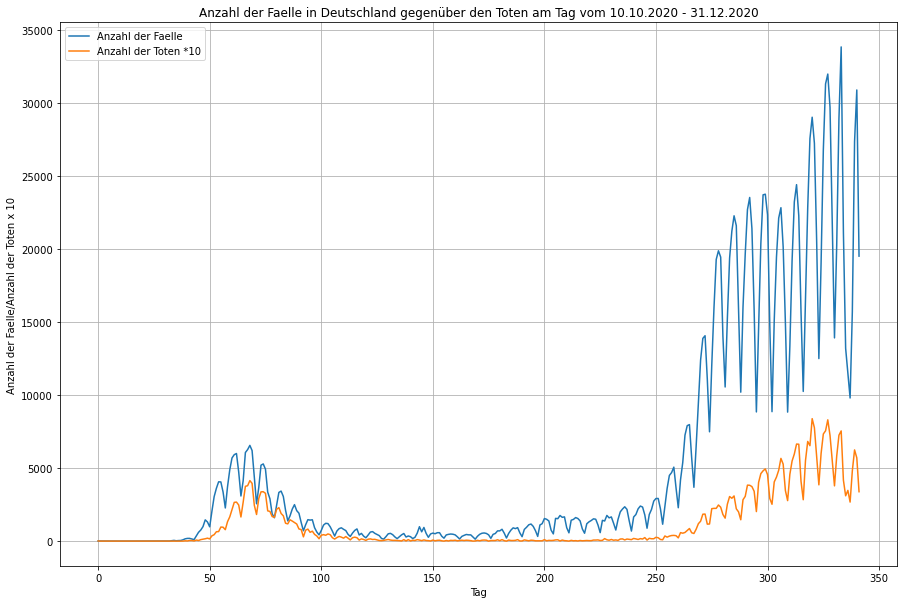

In [14]:
covid_data_germany = pd.read_csv('covid-19.csv',sep=';')

covid_data_germany = covid_data_germany.dropna()

faelle_nach_datum = list(covid_data_germany['Faelle'])
todesfaelle_nach_datum = list(covid_data_germany['Todesfaelle']*10)

plt.plot(faelle_nach_datum,label="Anzahl der Faelle") 
plt.plot(todesfaelle_nach_datum,label="Anzahl der Toten *10")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.legend()
plt.title("Anzahl der Faelle in Deutschland gegenüber den Toten am Tag vom 10.10.2020 - 31.12.2020")
plt.xlabel("Tag")
plt.ylabel("Anzahl der Faelle/Anzahl der Toten x 10")
plt.grid()
plt.show()

Des Weiteren wird eine Grafik geplottet, welche die Anzahl der Infektionen mit der Anzahl der Toten zwischen dem 10.10.2020 und 31.12.2020 in Deutschland dargestellt, da in diesem Zeitraum die Daten maximale Werte aufweisen und Zusammenhänge besser ersichtlich sind.

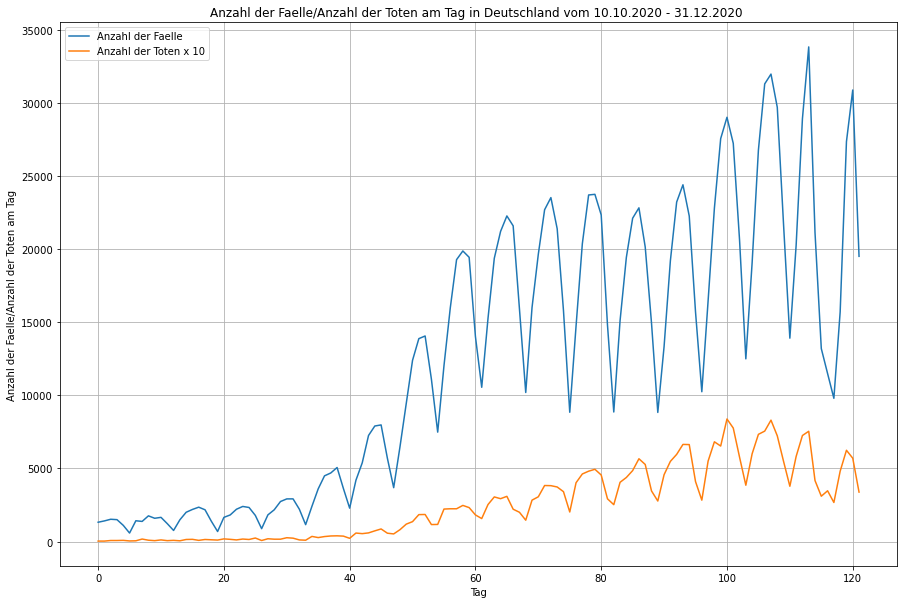

In [15]:
plt.plot(faelle_nach_datum[220:],label="Anzahl der Faelle")
plt.plot(todesfaelle_nach_datum[220:],label="Anzahl der Toten x 10")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("Anzahl der Faelle/Anzahl der Toten am Tag in Deutschland vom 10.10.2020 - 31.12.2020 ")
plt.xlabel("Tag")
plt.ylabel("Anzahl der Faelle/Anzahl der Toten am Tag")
plt.legend()
plt.grid()
plt.show()

Aus bereits oben genannten Gründen wird wieder der 7 Tage Moving Average der Daten bestimmt.

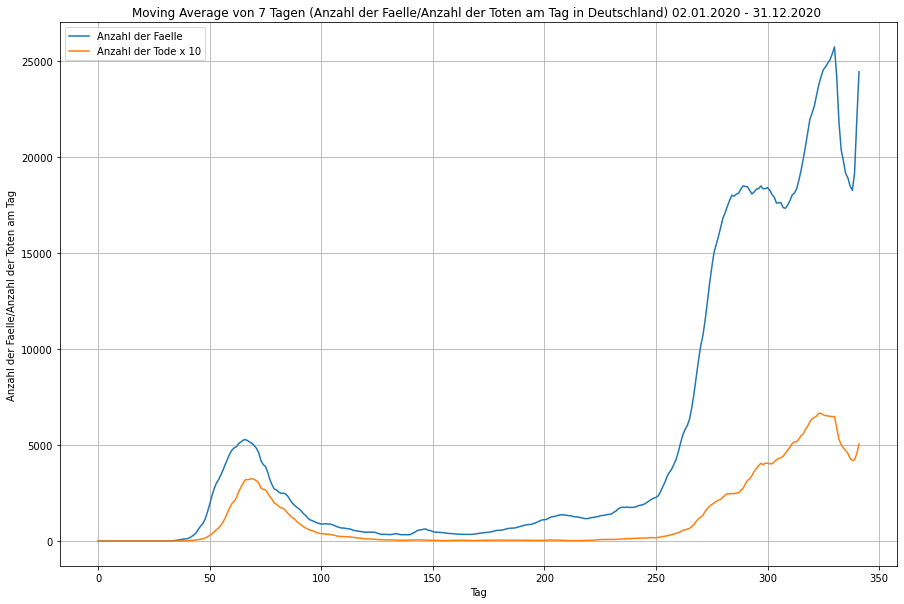

In [16]:
N = 7
anzahl_faelle_list_rm = uniform_filter1d(faelle_nach_datum, size=N)
anzahl_tode_list_rm = uniform_filter1d(todesfaelle_nach_datum, size=N)

plt.plot(anzahl_faelle_list_rm,label="Anzahl der Faelle")
plt.plot(anzahl_tode_list_rm,label="Anzahl der Tode x 10")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("Moving Average von 7 Tagen (Anzahl der Faelle/Anzahl der Toten am Tag in Deutschland) 02.01.2020 - 31.12.2020 ")
plt.xlabel("Tag")
plt.ylabel("Anzahl der Faelle/Anzahl der Toten am Tag")
plt.legend()
plt.grid()
plt.show()

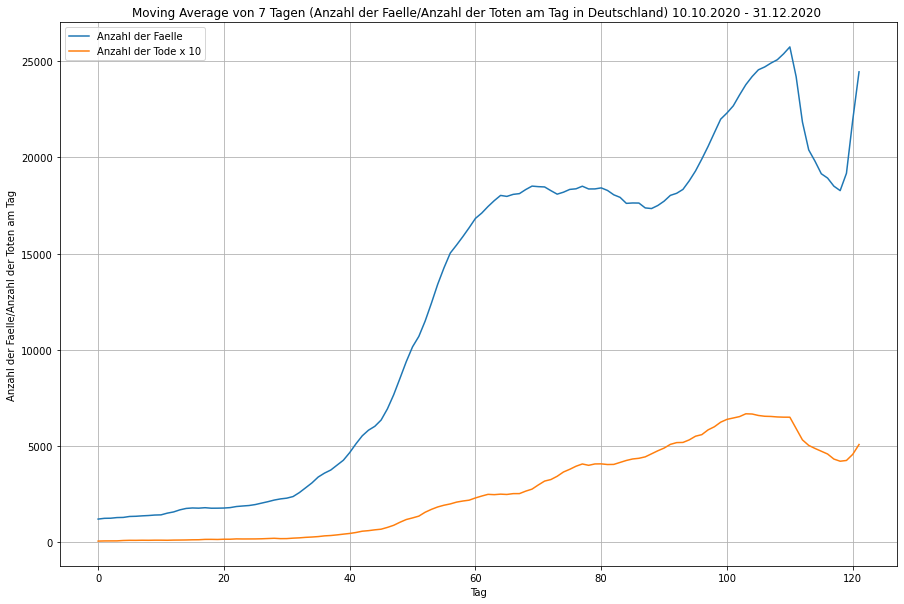

In [17]:
plt.plot(anzahl_faelle_list_rm[220:],label="Anzahl der Faelle")
plt.plot(anzahl_tode_list_rm[220:],label="Anzahl der Tode x 10")
fig = plt.gcf()
fig.set_size_inches(15,10)
plt.title("Moving Average von 7 Tagen (Anzahl der Faelle/Anzahl der Toten am Tag in Deutschland) 10.10.2020 - 31.12.2020 ")
plt.xlabel("Tag")
plt.ylabel("Anzahl der Faelle/Anzahl der Toten am Tag")
plt.legend()
plt.grid()
plt.show()

Außerdem wird die Korrelation bestimmt.

Maximum von 0.94 nach 24 Tagen


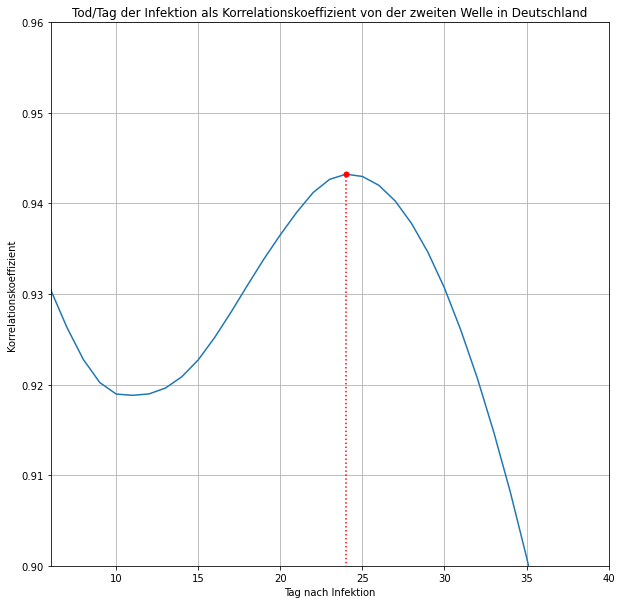

In [18]:
#Werte aus 2021 aussortieren
#anzahl_faelle_list_rm = anzahl_faelle_list_rm[:-16]
#anzahl_tode_list_rm = anzahl_tode_list_rm[:-16]
    
corrs = []

for i in range(1,50):
    corr,p= pearsonr(anzahl_faelle_list_rm[220:-i], anzahl_tode_list_rm[220+i:])
    corrs.append(corr)


corr_max = np.max(corrs[5:])
corr_arg_max = np.argmax(corrs[5:])+5

print("Maximum von "+ str(round(corr_max,2)) + " nach " + str(corr_arg_max) + " Tagen")

plt.plot(corrs,label="Korrelationskoeffizient der Infektionsfaellen zu den Todesfaellen")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.xlabel("Tag nach Infektion")
plt.title("Tod/Tag der Infektion als Korrelationskoeffizient von der zweiten Welle in Deutschland")
plt.ylabel("Korrelationskoeffizient")
plt.xlim([6,40])
plt.ylim([0.9,0.96])

plt.plot(corr_arg_max, corr_max, marker='o', markersize=5, color="red")
plt.vlines(corr_arg_max,0,corr_max,color='red', linestyle='dotted')
plt.grid()
plt.show()

Die Korrelation hat bei 24 Tagen ihr Maximum mit 0.94.

## Zusammenfassung:
- Es ist keine Korrelation zwischen Feinstaubdaten und Coronadaten Mannheim. Zu beachten ist allerdings, dass eine Korrelation auch nicht heißen würde, dass durch Erhöhung der Feinstaubwerte eine Erhöhung der Coronainfektionen hervorgerufen wird oder anders herum, sondern wenn, dann einen Zusammenhang mit den Maßnahmen gehabt hätte.
- Die Korrelation zwischen Infektionen und Todeszahlen in Mannheim zeigt eine Korrelation von 0.64 an Tag 20 (bezogen auf das Infektionsdatum) auf
- Die Korrelation zwischen Infektionen und Todeszahlen in Deutschland zeigt eine Korrelation von 0.94 bei ca. 24 Tagen (bezogen auf das Infektionsdatum)

## Herausforderungen:
1. Daten einlesen (Datum konvertieren, nicht vorhandene Daten auffüllen, Daten aus mehreren Zellen aufsummieren)
2. Zeitverschiebung von Coronainfektionen und Todeszahlen
3. Korrelation am Anfang der Zeitdifferenz hoch